# Lecture 12: Outliers and Imputation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

sns.reset_orig()
sns.set(font_scale=1.5)
%matplotlib inline

---

# Gaussian Outliers

In [2]:
%reload_ext sql
%sql postgresql://localhost:5432/postgres

Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [3]:
%sql SELECT setseed(0.42) -- to fix randomness

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

setseed
""


Just like a Python package, we need to import `tablefunc` in order to use the `normal_rand` function.

In [4]:
%sql CREATE EXTENSION IF NOT EXISTS tablefunc;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Assume our datapoints are truly Normal. Simulate them in `observations`.
* 1000 datapoints, $\mu = 50, \sigma = 5$.

In [5]:
%%sql
DROP TABLE IF EXISTS observations CASCADE;
CREATE TABLE observations AS (
    SELECT normal_rand AS x
    FROM normal_rand(1000, 50, 5)
);

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

++
||
++
++

In [6]:
results = %sql SELECT x FROM observations;

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

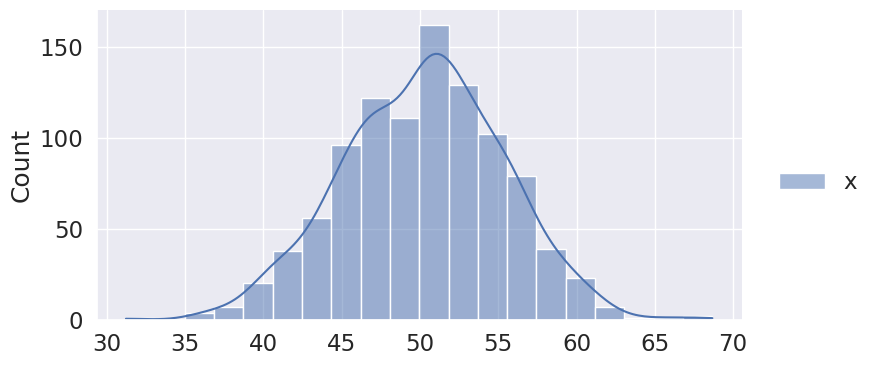

In [7]:
sns.displot(results.dict(), fill=True, kde=True, bins=20,
            height=4, aspect=2)

Construct a view called `normal_outliers` using the **2 sigma** metric.

In [8]:
# construct the view

In [9]:
%%sql
CREATE OR REPLACE VIEW normal_outliers AS
WITH bounds AS (
   SELECT avg(x) - 2*stddev(x) AS lo,
   avg(x) + 2*stddev(x) AS hi
   FROM observations
)
SELECT x AS outlier
FROM observations o, bounds b 
WHERE x NOT BETWEEN b.lo AND b.hi;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [10]:
# query the view
%sql SELECT * FROM normal_outliers;

Running query in 'postgresql://localhost:5432/postgres'

41 rows affected.

outlier
38.77398645435416
39.565436150228415
62.16075757510076
67.10880654989188
38.613250285067046
36.56205762377803
62.9226636874908
36.3591534642134
65.89723294885194
36.5387269972338


## What does this code do?

In [11]:
%%sql << results
SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)

Running query in 'postgresql://localhost:5432/postgres'

RuntimeError: If using snippets, you may pass the --with argument explicitly.
For more details please refer: https://jupysql.ploomber.io/en/latest/compose.html#with-argument


Original error message from DB driver:
(psycopg2.errors.SyntaxError) syntax error at or near "results"
LINE 1: results
        ^

[SQL: results
SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)]
(Background on this error at: https://sqlalche.me/e/20/f405)

If you need help solving this issue, send us a message: https://ploomber.io/community


In [ ]:
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
            height=4, aspect=1.5)
plt.xlim(30, 70)

<br/><br/><br/>
<br/><br/><br/>
<br/><br/><br/>

## Choices [hidden]

**A.**

In [ ]:
## plots outliers and original
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**B.**

In [ ]:
# correct
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers);

sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**C.**

In [ ]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers) \
               UNION ALL \
               SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers);

sns.displot(
    results.dict(), x="x", kind='hist',
    hue='label', kde=True, bins=20,
    height=4, aspect=2
)
plt.xlim(30, 70)

**D.**

In [ ]:
results = %sql SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

## What if we suddenly had extremes?

In [ ]:
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

In [ ]:
%sql SELECT min(x), max(x) FROM observations

In [ ]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers);

sns.displot(
    results.dict(), x="x", kind='hist',
    hue='label', kde=True, bins=np.linspace(32, 70, 20),
    height=4, aspect=1.5, rug=True
)
plt.xlim(30, 700)

In [ ]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers);

sns.displot(
    results.dict(), x="x", kind='hist',
    hue='label', kde=True, bins=np.linspace(32, 70, 20),
    height=4, aspect=1.5, rug=True
)
plt.xlim(30, 70)

In [ ]:
## reset before moving on
%sql UPDATE observations SET x = x/10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

# Winsorization

In [ ]:
import numpy as np

In [ ]:
arr = np.array([92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, -40, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr

In [ ]:
np.mean(arr), np.median(arr)

In [ ]:
np.percentile(arr, 9.5, method='nearest')

In [ ]:
np.percentile(arr, 5, method='nearest')

In [ ]:
arr_winsorized = np.array([92, 19, 101, 58, 101, 91, 26, 78, 10, 13, -5, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr_winsorized

In [ ]:
np.mean(arr_winsorized), np.median(arr_winsorized)

# Trimming vs. Winsorizatoin

In [ ]:
%%sql
CREATE OR REPLACE VIEW p1p99 AS (
    SELECT
        percentile_cont(.01) WITHIN GROUP (ORDER BY x) AS p1,
        percentile_cont(.99) WITHIN GROUP (ORDER BY x) AS p99
    FROM observations
);

SELECT * FROM p1p99;

In [ ]:
%%sql
CREATE OR REPLACE VIEW trimmed_observations AS
SELECT o.x, 'trimmed' AS label
  FROM observations o, p1p99 p
 WHERE o.x BETWEEN p.p1 AND p.p99
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

CREATE OR REPLACE VIEW trimmed_outliers AS
SELECT o.*
  FROM observations o, p1p99 p
 WHERE o.x NOT BETWEEN p.p1 AND p.p99;

In [ ]:
results = %sql SELECT * FROM trimmed_observations;
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20,
           height=4, aspect=1.5)

## What happens with corrupted data?

In [ ]:
# corrupt one value
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Turns out, we still have as many outliers, which we trim.

Because we are trimming based on the order of the data and not on the distribution statistics (mean/SD)

In [ ]:
results = %sql SELECT * FROM trimmed_observations;

sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

## Winsorization

In [ ]:
## reset before moving on
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

In [ ]:
%%sql
CREATE OR REPLACE VIEW winsorized_observations AS
SELECT CASE WHEN o.x BETWEEN p.p1 AND p.p99 THEN o.x
            WHEN o.x < p.p1 THEN p.p1
            WHEN o.x > p.p99 THEN p.p99
        END AS x,
      'winsorized' AS label
  FROM observations o, p1p99 p
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

In [ ]:
results = %sql SELECT * from winsorized_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

In [ ]:
%%sql 
SELECT 'orig' AS distribution, min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM observations
UNION ALL
SELECT 'winsorized', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM winsorized_observations WHERE label = 'winsorized'
UNION ALL 
SELECT 'trimmed', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM trimmed_observations WHERE label = 'trimmed';

# Robustness, Mean, Median, Hampel X84

In [ ]:
%%sql
-- percentile_disc returns an actual data value near the percentile
-- percentile_cont returns an interpolated value at the percentile
CREATE OR REPLACE VIEW median AS
(SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median
  FROM observations);

In [ ]:
%%sql
CREATE OR REPLACE VIEW mad AS
WITH
absdevs AS
(SELECT abs(x - median) as d
   FROM observations, median)
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY d) as mad
  FROM absdevs;
    
SELECT median, mad
  FROM median, mad;

In [ ]:
%%sql
CREATE OR REPLACE VIEW hampelx84x2_observations AS
SELECT o.x,
      'hampelx84x2' AS label
  FROM observations o, median, mad
 WHERE o.x BETWEEN (median-2*1.4826*mad) AND (median+2*1.4826*mad)
UNION ALL
SELECT o.x, 'orig' AS label
  FROM observations o;

CREATE OR REPLACE VIEW Hampel84x2_outliers AS
SELECT x
  FROM observations o, median, mad
 WHERE x NOT BETWEEN (median - 2*1.4826*mad) AND (median + 2*1.4826*mad);

In [ ]:
results = %sql SELECT * FROM hampelx84x2_observations;

sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

# GNIS data

This is the GNIS dataset from the previous lecture. If you didn't load in the database, run the below cell before connecting.

In [ ]:
!psql -h localhost -d gnis -c 'SELECT pg_terminate_backend(pg_stat_activity.pid) FROM pg_stat_activity WHERE datname = current_database() AND pid <> pg_backend_pid();'
!psql -h localhost -c 'DROP DATABASE IF EXISTS gnis'
!psql -h localhost -c 'CREATE DATABASE gnis' 
!psql -h localhost -d gnis -f ../lec11/data/gnis.sql

In [ ]:
%reload_ext sql
%sql postgresql://localhost:5432/gnis

In [ ]:
%sql SELECT setseed(0.12345);

In [ ]:
%%sql
DROP TABLE IF EXISTS holey CASCADE;
CREATE TABLE holey AS
SELECT feature_id, feature_name, feature_class, state_alpha, county_name, 
       prim_lat_dec, prim_long_dec,
       CASE WHEN random() > 0.9 THEN NULL
            ELSE elev_in_m
        END AS elev_in_m
  FROM national;
SELECT count(elev_in_m)::float / count(*) FROM holey;

## Schema 1. Default Value Imputation with SQL

In [ ]:
%%sql
WITH elevavg AS (SELECT avg(elev_in_m) FROM holey)
SELECT h.*,
       CASE WHEN h.elev_in_m IS NOT NULL THEN h.elev_in_m
            ELSE e.avg
        END AS imputed_elev_in_m
  FROM holey h, elevavg e
LIMIT 10;

## Scheme 2. Correlation across columns

In [ ]:
# Training is an aggregate function
# Here we'll train the model in SQL just for fun
result = %sql SELECT regr_slope(elev_in_m, prim_long_dec), \
               regr_intercept(elev_in_m, prim_long_dec) FROM holey
slope, intercept = result[0]
slope, intercept

In [ ]:
%%sql
SELECT *, 
       CASE WHEN elev_in_m IS NOT NULL THEN elev_in_m
            ELSE {{slope}}*prim_long_dec + {{intercept}}
        END AS imputed_elev_in_m
  FROM holey
LIMIT 10;

## Scheme 3. General model-based interpolation

We won't show the demo; check slides for the general idea.

In [ ]:

%config SqlMagic.displaylimit = 100

## Scheme 4. [simple] Correlation across ordered rows

In [ ]:
%%sql
-- The following doesn't work in PostgreSQL!
WITH buggy AS (
SELECT *,
       CASE WHEN elev_in_m IS NOT NULL THEN elev_in_m
            ELSE lag(elev_in_m, 1)
                 OVER (ORDER BY feature_id)
        END AS imputed_elev_in_m
  FROM holey
)
SELECT * FROM buggy ORDER BY elev_in_m DESC LIMIT 100;

In [ ]:
%%sql
-- Here's a UDA fix from
-- https://stackoverflow.com/questions/18987791/how-do-i-efficiently-select-the-previous-non-null-value
CREATE OR REPLACE FUNCTION coalesce_agg_sfunc(state anyelement, value anyelement) RETURNS anyelement AS
$$
    SELECT coalesce(value, state);
$$ LANGUAGE SQL;

CREATE AGGREGATE coalesce_agg(anyelement) (
    SFUNC = coalesce_agg_sfunc,
    STYPE  = anyelement);

In [ ]:
%%sql
-- Fixed to handle repeated NULLs
WITH fixed AS (
SELECT *,
       coalesce_agg(elev_in_m) OVER (order by feature_id) AS imputed_elev_in_m
  FROM holey
)
SELECT * FROM fixed ORDER BY imputed_elev_in_m DESC LIMIT 100;